In [8]:
import h5py, os, glob, json
from block2 import SU2
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
import pandas as pd
import numpy as np
from dmrg_utils import load_mps, max_det_coeff, expand_csf
from cas_utils import log_hilbert_space_size
from matplotlib import pyplot as plt
from pathlib import Path
import urllib.request

In [9]:
# General parameters
repository_url = "https://github.com/isi-usc-edu/qb-gsee-benchmark/archive/refs/heads/main.zip"
problem_instance_files_repository_path = (
    "problem_instances"
)

In [10]:
# Download problem instance files
repository_filepath = Path("repository.zip")

repository_path = Path("qb-gsee-benchmark-main")
if not repository_path.exists():
    # Download repository
    urllib.request.urlretrieve(repository_url, repository_filepath.name)
    # unzip repository
    os.system(f"unzip {repository_filepath}")

problem_instance_files_path = repository_path / problem_instance_files_repository_path
instance_files = list(problem_instance_files_path.glob('problem_instance.planted_solution_*.json'))

In [11]:
# Retrieve relevant metadata
metadata = []

for file in instance_files:
    with open(file, 'r') as jf:
        json_data = json.load(jf)
    
    
    for task_data in json_data['tasks']:
        features = dict(task_data['features'])
        assert len(task_data['supporting_files']) == 1 
        features = {**features, **(task_data['supporting_files'][0])}
        features['reference_energy'] = task_data['requirements'].get('reference_energy')
        features['reference_energy_units'] = task_data['requirements'].get('reference_energy_units')
        features['task_uuid'] = task_data['task_uuid']

    file_name = os.path.basename(file)
    features['prob_file_name'] = file_name

    metadata.append(features)

metadata = pd.DataFrame(metadata)
metadata['prob_name_wo_uuid'] = metadata.apply(lambda r: r['prob_file_name'].split('.')[1], axis=1)

In [ ]:
mps_data_dir = Path('../data/data_storage/') # Location of MPSs; in this example - for planted solutions
list_of_solution_dirs = list(mps_data_dir.glob('planted_solution_*'))
solution_paths = []
for sol_dir in list_of_solution_dirs:
    prob_name = os.path.basename(sol_dir).split('.')[0]
    solution_paths.append({'prob_name_wo_uuid' : prob_name, 'solution_dir' : sol_dir})
sol_paths = pd.DataFrame(solution_paths)
print(sol_paths.head(1))

       prob_name_wo_uuid                                       solution_dir
0  planted_solution_0004  ../data/data_storage/planted_solution_0004.7e0...


In [13]:
metadata = metadata.join(sol_paths.set_index('prob_name_wo_uuid'), on='prob_name_wo_uuid', how='left')
metadata['log10_hs_size'] = metadata.apply(lambda r: log_hilbert_space_size(r['num_orbitals'], 
                                                     r['num_electrons'], r['multiplicity']), axis=1)
metadata.head(1)

,multiplicity,num_electrons,num_orbitals,utility_scale,instance_data_object_uuid,instance_data_object_url,instance_data_checksum,instance_data_checksum_type,reference_energy,reference_energy_units,task_uuid,prob_file_name,prob_name_wo_uuid,solution_dir,log10_hs_size
0,1,50,31,False,efddd28a-383d-4929-9335-22e54ba2ffbe,sftp://sftp.l3harris.com/gsee/planted_solution...,48e4bda8ad2e48926e8b7c36ea24f1e16ab8edf2,sha1sum,-581.589915,hartree,472bbfb1-c081-4df6-b966-32ce1194ab8c,problem_instance.planted_solution_0003.a37c86c...,planted_solution_0003,../data/data_storage/planted_solution_0003.70f...,11.734087


In [14]:
metadata[['prob_name_wo_uuid', 'log10_hs_size', 'num_orbitals']]

,prob_name_wo_uuid,log10_hs_size,num_orbitals
0,planted_solution_0003,11.734087,31
1,planted_solution_0009,36.725579,69
2,planted_solution_0004,37.619895,70
3,planted_solution_0008,6.602928,14
4,planted_solution_0011,11.734087,31
5,planted_solution_0005,6.955111,14
6,planted_solution_0002,36.725579,69
7,planted_solution_0006,6.602928,14
8,planted_solution_0010,11.547244,30
9,planted_solution_0001,6.602928,14


In [15]:
overlap_data = []
for index, row in metadata.iterrows():

    n_electrons = int(row["num_electrons"])
    spin = int(row["multiplicity"]) - 1
    n_cas = int(row["num_orbitals"])

    full_path_to_solution = row['solution_dir']
    print(f'Path to MPSs: {full_path_to_solution}')
    
    with h5py.File(full_path_to_solution/'dmrg_results.hdf5', 'r') as f:
        loop_bd_info = {} 
        for k in f.keys():
            if 'dmrg_loop_' in k:
                loop_num = int(k.split('_')[-1])
                max_bd = np.max(np.array(f[k]['dmrg_parameters']['sweep_schedule_bond_dims']))
                loop_bd_info[loop_num] = max_bd

        n_loops = len(loop_bd_info)

    for loop in range(1, n_loops + 1):

        driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
        driver.initialize_system(
            n_sites=int(n_cas),
            n_elec=int(n_electrons),
            spin=int(spin),
        )

        if loop > 9:
            full_dir = full_path_to_solution/'mps_storage'/f'dmrg_loop_0{loop}_ket_optimized'
        else:
            full_dir = full_path_to_solution/'mps_storage'/f'dmrg_loop_00{loop}_ket_optimized'

        print(full_dir)

        assert os.path.isfile(full_dir/'mps_info.bin')

        ket = load_mps(full_dir)
        #bd = ket.info.bond_dim # may not display the correct value
        bd = loop_bd_info[loop]

        coeff, csf = max_det_coeff(driver, ket, cutoff=0.0005)
        #zcsf = expand_csf(driver, csf, 
        #                  ne=int(n_electrons), 
        #                  no=int(n_cas), spin=int(spin))
        #dets, coeffs = driver.get_csf_coefficients(zcsf, cutoff=1e-6, iprint=0)


        overlap_data.append({'prob_name_wo_uuid' : row['prob_name_wo_uuid'],
                             'loop' : loop,
                             'num_orbitals' : row['num_orbitals'], 
                             'num_electrons' : row['num_electrons'], 
                             'bond_dimension' : bd,
                             'hf_coeff' : np.abs(coeff), 
                             'csf' : csf, 'n_dets' : None})
                             # 'n_dets' : len(dets), })
                             #'z_s1' : z_s1 })
        

Path to MPSs: ../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173-bf314a229153
../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173-bf314a229153/mps_storage/dmrg_loop_001_ket_optimized
../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173-bf314a229153/mps_storage/dmrg_loop_002_ket_optimized
../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173-bf314a229153/mps_storage/dmrg_loop_003_ket_optimized
../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173-bf314a229153/mps_storage/dmrg_loop_004_ket_optimized
../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173-bf314a229153/mps_storage/dmrg_loop_005_ket_optimized
../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173-bf314a229153/mps_storage/dmrg_loop_006_ket_optimized
../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173-bf314a229153/mps_storage/dmrg_loop_007_ket_optimized
../data/data_storage/planted_solution_0003.70f02aa9-7e8f-481c-a173

In [16]:
overlaps = pd.DataFrame(overlap_data)
#overlaps = overlaps.join(metadata_.set_index('task_uuid'), on='task_uuid', how='left')
overlaps.head()

,prob_name_wo_uuid,loop,num_orbitals,num_electrons,bond_dimension,hf_coeff,csf,n_dets
0,planted_solution_0003,1,31,50,6,0.976323,"[0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",None
1,planted_solution_0003,2,31,50,7,0.977222,"[0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",None
2,planted_solution_0003,3,31,50,8,0.977415,"[0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",None
3,planted_solution_0003,4,31,50,9,0.976903,"[0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",None
4,planted_solution_0003,5,31,50,10,0.976597,"[0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",None


In [17]:
#overlaps.shape
overlaps.columns

Index(['prob_name_wo_uuid', 'loop', 'num_orbitals', 'num_electrons',
       'bond_dimension', 'hf_coeff', 'csf', 'n_dets'],
      dtype='object')

In [18]:
overlaps.prob_name_wo_uuid.unique()

array(['planted_solution_0003', 'planted_solution_0009',
       'planted_solution_0004', 'planted_solution_0008',
       'planted_solution_0011', 'planted_solution_0005',
       'planted_solution_0002', 'planted_solution_0006',
       'planted_solution_0010', 'planted_solution_0001',
       'planted_solution_0007'], dtype=object)

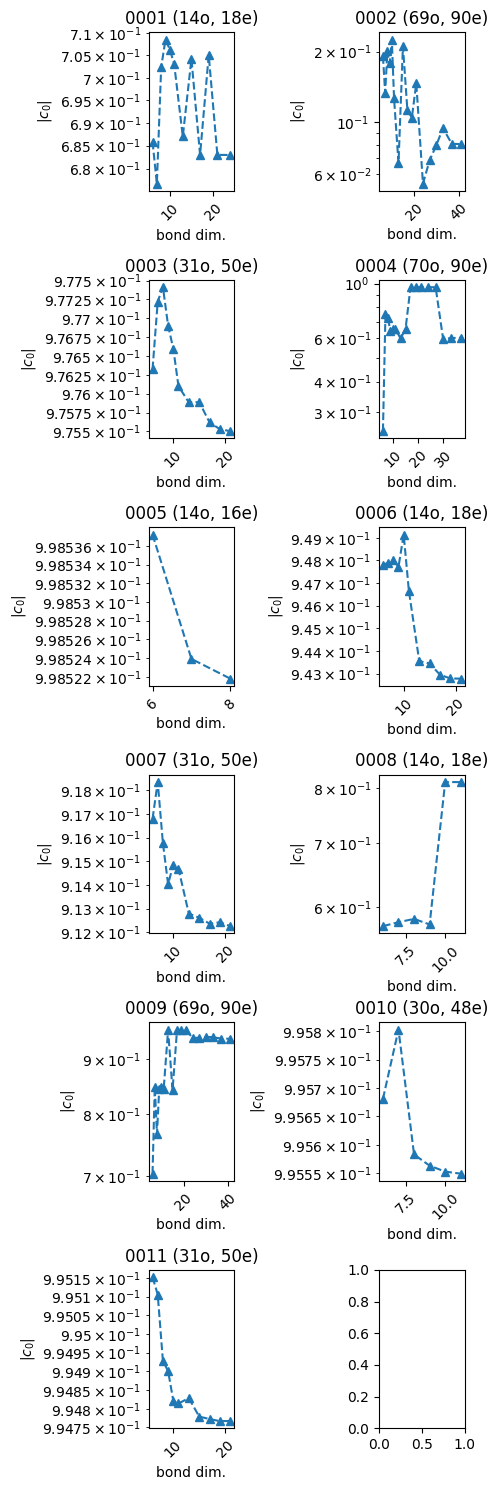

In [19]:
fig, ax = plt.subplots(6, 2, figsize=(5, 15))
ax_ = ax.flatten()
index = 0
for id_, group_ in overlaps.groupby('prob_name_wo_uuid'):
    bd = group_['bond_dimension'].to_numpy()
    abs_hf_coeff = group_['hf_coeff'].to_numpy()
    p = np.argsort(bd)
    no_tag = group_["num_orbitals"].unique()[0]
    ne_tag = group_['num_electrons'].unique()[0]
    ax_[index].plot(bd[p], abs_hf_coeff[p], '^--')
    ax_[index].set_xlabel('bond dim.')
    ax_[index].tick_params(axis='x', labelrotation=45)
    ax_[index].set_ylabel(r'$|c_0|$')
    ax_[index].set_yscale('log')
    ax_[index].set_title(f'{id_.split("_")[-1]} ({int(no_tag)}o, {int(ne_tag)}e)')
    index += 1

fig.tight_layout()
plt.savefig('overlaps.png', dpi=300)

In [20]:
overlaps_summary = overlaps.groupby('prob_name_wo_uuid').max('loop')
overlaps_summary.head()

,loop,num_orbitals,num_electrons,bond_dimension,hf_coeff
prob_name_wo_uuid,,,,,
planted_solution_0001,12,14,18,24,0.708597
planted_solution_0002,17,69,90,41,0.225133
planted_solution_0003,11,31,50,21,0.977415
planted_solution_0004,16,70,90,37,0.968532
planted_solution_0005,3,14,16,8,0.998537


In [29]:
#overlaps_summary = overlaps_summary.join(metadata[['prob_name_wo_uuid', 'instance_data_object_url']].set_index('prob_name_wo_uuid'), on='prob_name_wo_uuid', how='left')
overlaps_summary = overlaps_summary.join(metadata[['prob_name_wo_uuid', 'task_uuid']].set_index('prob_name_wo_uuid'), on='prob_name_wo_uuid', how='left')

In [30]:
overlaps_summary.rename(columns={'hf_coeff' : 'overlap'}, inplace=True)
overlaps_summary[['overlap', 'task_uuid']].to_csv('overlaps.csv', index=False)